In [1]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: scipy>=0.13.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from scikit-learn)
Requirement not upgraded as not directly required: numpy>=1.8.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from scikit-learn)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# The code was removed by Watson Studio for sharing.

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,pub_rec_bankruptcies,tax_liens,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,CHARGED_OFF
0,1,5000.0,5000.0,4975.0,36.0,10.65,162.87,B,B2,NaN,...,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,2500.0,2500.0,2500.0,60.0,15.27,59.83,C,C4,Ryder,...,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

### No point of evaluating loans with loan_amnt or total_acc to null.
### Also emp_title and title create too many dummy categories

In [5]:
loans_raw.dropna(subset=['loan_amnt', 'total_acc'], inplace=True)
loans_raw.drop(columns=['emp_title', 'title'], axis='1', inplace=True)

### List missing values aggregation

In [6]:
missing_values_table(loans_raw)

Your selected dataframe has 52 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
debt_settlement_flag_date,42346,99.6
settlement_status,42346,99.6
settlement_date,42346,99.6
settlement_amount,42346,99.6
settlement_percentage,42346,99.6
settlement_term,42346,99.6
next_pymnt_d,39786,93.6
mths_since_last_record,38855,91.4
mths_since_last_delinq,26897,63.3
desc,13292,31.3


### Drop variables with too many nulls

In [7]:
too_many_na = ["settlement_term", "settlement_percentage", "settlement_amount", "settlement_date",  "settlement_status", "debt_settlement_flag_date", "next_pymnt_d", "desc", "mths_since_last_record", "mths_since_last_delinq"]
loans_raw.drop(columns=too_many_na, inplace=True)


In [8]:
missing_values_table(loans_raw)

Your selected dataframe has 42 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
pub_rec_bankruptcies,1336,3.1
emp_length,1112,2.6
last_pymnt_d,83,0.2
tax_liens,76,0.2
revol_util,61,0.1
last_credit_pull_d,3,0.0


In [9]:
from sklearn.model_selection import train_test_split
credits_train, credits_test = train_test_split(loans_raw, test_size=0.2, random_state=42)

In [10]:
credits_target = credits_train["CHARGED_OFF"].copy()
credits_train = credits_train.drop("CHARGED_OFF", axis=1)

In [11]:
credits_num = credits_train.select_dtypes(exclude=['object'])
credits_cat = credits_train.select_dtypes(include=['object'])
num_attribs = credits_num.columns
cat_attribs = credits_cat.columns

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('oh_encoder', OneHotEncoder()),
    ])

In [13]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

credits_prepared = full_pipeline.fit_transform(credits_train)


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(credits_prepared, credits_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np

np.mean(cross_val_score(rf_classifier, credits_prepared, credits_target, cv=10, scoring="f1"))

0.95729671449798082

In [16]:
from sklearn.model_selection import cross_val_predict
credits_predicted = cross_val_predict(rf_classifier, credits_prepared, credits_target, cv=10)

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
confusion_matrix(credits_target, credits_predicted)

array([[29357,    57],
       [  288,  4302]])

In [18]:
precision_score(credits_target, credits_predicted)

0.98692360633172749

In [19]:
recall_score(credits_target, credits_predicted)

0.93725490196078431

In [20]:
dummies = pd.get_dummies(credits_train[cat_attribs])

In [21]:
dummies.columns.size

2868

In [22]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [23]:
importances.shape

(2895,)

In [24]:
importances[indices[2]]

0.052487241253104222

In [25]:
# Print the feature ranking
print("Feature ranking:")

delete_importance=[]

for f in range(credits_prepared.shape[1]):
    if (importances[indices[f]]) > 5e-4:
        print("%d. feature %s (%.4e)" % (f + 1, dummies.columns[f], importances[indices[f]]))
    else:
        delete_importance.append(f)

importance_mini = np.delete(importances, delete_importance)

Feature ranking:
1. feature grade_A (2.6045e-01)
2. feature grade_B (2.0050e-01)
3. feature grade_C (5.2487e-02)
4. feature grade_D (5.1972e-02)
5. feature grade_E (4.2971e-02)
6. feature grade_F (3.1025e-02)
7. feature grade_G (3.0578e-02)
8. feature sub_grade_A1 (2.5425e-02)
9. feature sub_grade_A2 (1.4478e-02)
10. feature sub_grade_A3 (1.2372e-02)
11. feature sub_grade_A4 (1.2002e-02)
12. feature sub_grade_A5 (1.1286e-02)
13. feature sub_grade_B1 (1.0653e-02)
14. feature sub_grade_B2 (1.0631e-02)
15. feature sub_grade_B3 (9.4098e-03)
16. feature sub_grade_B4 (7.1932e-03)
17. feature sub_grade_B5 (6.1861e-03)
18. feature sub_grade_C1 (5.4100e-03)
19. feature sub_grade_C2 (5.3506e-03)
20. feature sub_grade_C3 (5.1767e-03)
21. feature sub_grade_C4 (4.7010e-03)
22. feature sub_grade_C5 (4.6402e-03)
23. feature sub_grade_D1 (3.8221e-03)
24. feature sub_grade_D2 (3.2554e-03)
25. feature sub_grade_D3 (3.1825e-03)
26. feature sub_grade_D4 (2.7128e-03)
27. feature sub_grade_D5 (2.4475e-03)
2

In [26]:
importance_mini.shape
indices_mini = np.argsort(importance_mini)[::-1]

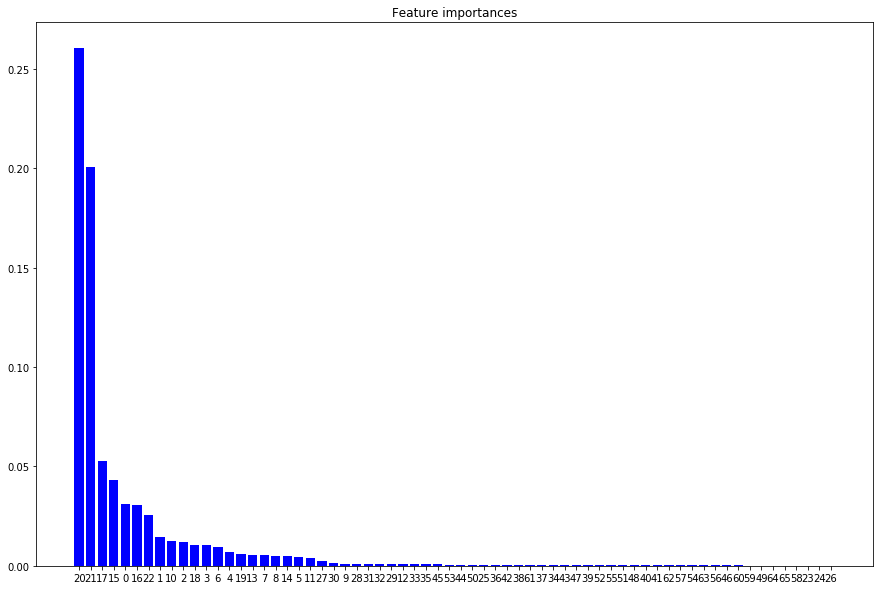

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(importance_mini.size), importance_mini[indices_mini], color="b", align="center")
plt.xticks(range(importance_mini.size), indices_mini)
plt.show()